In [1]:
from utils.readfile import*
from utils.barrel_data import*
from utils.doublet import*
from utils.triplet import*
from utils.plotting_utils import*
from utils.track_reconstruction_metric_triplet_level  import*
from utils.track_reconstruction_metric_hit_level  import*
from importlib import reload
import yaml
import json
from tqdm import tqdm
import pickle
from utils.cellular_automata import*
from utils.triplet_fit import*
class generated_tracks:
    pass

pd.set_option('display.max_columns', None) 

with open('files/pdgids.pkl','rb') as f:
    pdg_dict = pickle.load(f)
with open("config.yaml", "r") as f:

    # Load and parse the YAML file
    config = yaml.safe_load(f)
barrel_data = get_barrel_data(config)
config['sigma_cut'] = 3
layer_files = ['z0','dtheta','dkappa']
get_layer_wise_data(layer_files,config)
def fname(eno):


    triplet_arr_fname  = f'generated_tracks/triplets/chi2_7_triplet_arr{eno}.pkl'
    triplet_df_fname  = f'generated_tracks/triplets/chi2_7_triplet_df{eno}.pkl'
    ca_fname = f'generated_tracks/ca_class_eno_{eno}.pkl'
    # triplet_fname = stage_dir+f'{track_segments}_eventno_'+str(eno)+'_signal_'+str(signal)+'_z0_'+str(z0)+'_pt_'+str(pt)+'.pkl'
    return triplet_arr_fname,triplet_df_fname,ca_fname


def load_triplets(eno):
    triplet_arr_fname,triplet_df_fname,_ = fname(eno)
    with open(triplet_arr_fname,'rb') as f:
        triplet_arr = pickle.load(f)
    with open(triplet_df_fname,'rb') as f:
        triplet_df = pickle.load(f)
    config['chi_square_cut'] = 6
    return triplet_array_after_chi2_cut(triplet_arr,triplet_df,config)    



def load_ca(eno):
    _,_,ca_fname = fname(eno)
    with open(ca_fname,'rb') as f:
        ca = pickle.load(f)
    return ca



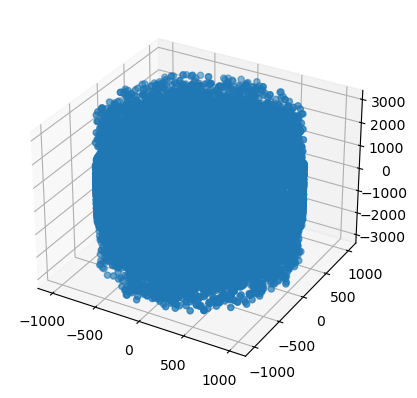

In [2]:
hdf,pdf = read_files(0)

##plot the x,y,z in 3d with matplotlif -hdf.x etc 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hdf.x,hdf.y,hdf.z)
# ax.scatter(pdf.x,pdf.y,pdf.z)
plt.show()

In [ ]:


base = "generated_tracks/triplet_level/inside_out/"

for eno in tqdm(range(90)):

    class_name = base + f'event_{eno}.pkl'
    with open(class_name,'rb') as f:
        track_class = pickle.load(f)


    triplet_arr_chi2,triplet_df_chi2 = load_triplets(eno)
    ca = load_ca(eno)

    track_collection = track_class.track_after_second_trimming

    for track in track_collection:
        triplet_object_array = []
        hits = []
        for iter,element in enumerate(track):
            iter  = 7-iter
            index_layer = np.where(triplet_df_chi2 == iter)[0]

            triplet_element = triplet_arr_chi2[index_layer][element]

            triplet_object_array.append(triplet_element)
            hits.extend(triplet_element.hitids)
        hits = np.unique(hits)
        hits = np.flip(hits)

        triplet_object_array.reverse()
        pid_ = hits_df[hits_df.hit_id.isin(hits)]['particle_id'].values  ##finsding particle id for all hits in a track
        unique, counts = np.unique(pid_, return_counts=True)
        
        if(np.max(counts)==10):  ##criterion for 100% matching 
            if pid_[0] in signal_pids:
                label.append(True)  
            else:
                label.append(False)         
        else:
            label.append(False)    
        df = hits_df[hits_df.hit_id.isin(hits[0:2])]
        z1 = df['z'].values[0]
        z2 = df['z'].values[1]
        r1 = df['r'].values[0]
        r2 = df['r'].values[1]
        dr = r2-r1
        dz = z2-z1
        theta  = np.arctan2(dr,dz)

        theta_array.append(theta)
        
        gttf_class = GTTF(triplet_object_array)
        
        
        curvature= gttf_class.C3D_glob

        momentum = (0.3/1000)*2/np.abs(curvature)
        momentum_array.append(momentum)

        chi2_gttf_array.append(gttf_class.chi2_glob)
        c3d_gttf_array.append(curvature)

        sigma_k = gttf_class.sigma_C3D_glob
        sigma_p = (0.3/1000)*2*sigma_k/(np.abs(curvature)**2)

        sigma_p_array.append(sigma_p)
        sigma_k_array.append(sigma_k)


    ca.theta_array = np.array(theta_array)
    ca.momentum_array = np.array(momentum_array)
    ca.sigma_p_array = np.array(sigma_p_array)
    ca.sigma_k_array = np.array(sigma_k_array)
    ca.label = np.array(label)
    ca.chi2_gttf_array = np.array(chi2_gttf_array)
    ca.c3d_gttf_array = np.array(c3d_gttf_array)



    # pt = momentum_array*theta_array

    # sigma_pt = pt*sigma_p_array
 
